In [ ]:
pip install rouge-score bert-score transformers hyperopt spacy-ngram evaluate wandb

In [2]:
import os
import pandas as pd
import re
import random
import spacy
from sklearn.model_selection import train_test_split
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch import cuda, tensor
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.optim as optim
from huggingface_hub import HfFolder, Repository, create_repo

from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import BertTokenizer, BertModel
from bert_score import BERTScorer
from evaluate import load

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from transformers import Trainer, TrainingArguments

# Data Processing

## Import raw data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cwd = '/content/drive/MyDrive/LLMs'
cwd

'/content/drive/MyDrive/LLMs'

In [ ]:
filename = f'{cwd}/subreddits_train_data_3.parquet'
raw_df = pd.read_parquet(filename)
raw_df.head()

,PostText
0,Text: This post contains content not supported...
1,Text: I still get asked for my ID when I go to...
2,Text: My mum and dad don't get thid Charleston...
3,Text: I’m 31
4,Text: Pageant makeup amirite?


In [ ]:
raw_df['PostText'].values[0]

'Text: This post contains content not supported on old Reddit.'

In [ ]:
raw_df.shape

(1836113, 1)

## Pre-processing

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
stopwords = nlp.Defaults.stop_words
len(stopwords)

326

In [ ]:
def remove_stopwords(text):
    keywords = []
    for item in nlp(text):
        if not item.is_stop:
            keywords.append(item.lemma_)
    keywords_para = ' '.join(keywords)

    return keywords_para

def extract_keywords(text):
    try:
        split_text = text.split("Text: ")
        text = split_text[1]
        keywords_para = remove_stopwords(text)

        return {
        "text": text,
        "keywords": keywords_para
        }
    except:
        return {'text': '', 'keywords': ''}

In [ ]:
batch_size = 300000

In [ ]:
i = 7

In [ ]:
keywords = []
texts = []
for ind, post in enumerate(raw_df['PostText'].values[(i - 1)*batch_size: ]):
    result = extract_keywords(post)
    keywords.append(result['keywords'])
    texts.append(result['text'])
    if ind % 50000 == 0:
        print(ind)

0


In [ ]:
df = pd.DataFrame({'text': texts, 'keywords': keywords})
df.tail()

,text,keywords
36108,"Every night at 630, like clockwork, the gremli...","night 630 , like clockwork , gremlin come ."
36109,,
36110,Kristi on the trail,Kristi trail
36111,Happy New Year!!,Happy New Year ! !
36112,3 Yr old cockapoo,3 yr old cockapoo


In [ ]:
df.shape

(300000, 2)

In [ ]:
fileno = str(i)
df.to_parquet(f'{cwd}/subreddits_train_data_3_keywords_lemm_{fileno}.parquet')

In [20]:
df = pd.read_parquet(f'{cwd}/subreddits_train_data_3_keywords_lemm_1.parquet')
df.head()

,text,keywords
0,This post contains content not supported on ol...,post contain content support old Reddit .
1,I still get asked for my ID when I go to clubs.,ask id club .
2,My mum and dad don't get thid Charleston music...,mum dad thid Charleston music like .
3,I’m 31,31
4,Pageant makeup amirite?,pageant makeup amirite ?


In [21]:
fileno = 2
# df = pd.read_parquet(f'{cwd}/subreddits_train_data_keywords.parquet')
df2 = pd.read_parquet(f'{cwd}/subreddits_train_data_3_keywords_lemm_{fileno}.parquet')
df_merged = pd.concat([df, df2], ignore_index=True, sort=False)
df.head()

,text,keywords
0,This post contains content not supported on ol...,post contain content support old Reddit .
1,I still get asked for my ID when I go to clubs.,ask id club .
2,My mum and dad don't get thid Charleston music...,mum dad thid Charleston music like .
3,I’m 31,31
4,Pageant makeup amirite?,pageant makeup amirite ?


In [ ]:
df2.tail()

,text,keywords
299995,I would love to see another season but im afra...,love season m afraid people want
299996,I'm super late but that bit made me laugh too ...,"super late bit laugh montage , proud let fade ..."
299997,As someone who has not watched the Zelda playt...,watch Zelda playthrough play game … watch gg p...
299998,I feel like watching them as they played it m...,feel like watch play make sense inside joke ...
299999,"Personally, I am very happy with what I got.","personally , happy get ."


In [22]:
for fileno in range(3, 8):
  df2 = pd.read_parquet(f'{cwd}/subreddits_train_data_3_keywords_lemm_{fileno}.parquet')
  df_merged = pd.concat([df_merged, df2], ignore_index=True, sort=False)
  df_merged = df_merged[df_merged['text'] != '']
  df_merged = df_merged[df_merged['keywords'] != '']
df_merged.head()

,text,keywords
0,This post contains content not supported on ol...,post contain content support old Reddit .
1,I still get asked for my ID when I go to clubs.,ask id club .
2,My mum and dad don't get thid Charleston music...,mum dad thid Charleston music like .
3,I’m 31,31
4,Pageant makeup amirite?,pageant makeup amirite ?


In [23]:
df_merged.shape

(1794510, 2)

In [ ]:
df_merged.tail()

,text,keywords
1471310,You know who this is.,know .
1471311,This sub single handedly strong armed me into ...,sub single handedly strong arm purchase mad .
1471312,Plus it's nice to shop a Canadian brand so I d...,plus nice shop canadian brand pay double tariff .
1471313,I had fun taking pics of this one at the park ...,fun take pic park dog time life chase fav socc...
1471314,Psilocybin by clionadh cosmetics in all it's ...,"Psilocybin clionadh cosmetic shifty , magnet..."


In [ ]:
df_merged.to_parquet(f'{cwd}/subreddits_train_data_merged_lemm.parquet')

In [24]:
df = pd.read_parquet(f'{cwd}/subreddits_train_data_merged_lemm.parquet')
df.head()

,text,keywords
0,This post contains content not supported on ol...,post contain content support old Reddit .
1,I still get asked for my ID when I go to clubs.,ask id club .
2,My mum and dad don't get thid Charleston music...,mum dad thid Charleston music like .
3,I’m 31,31
4,Pageant makeup amirite?,pageant makeup amirite ?


In [25]:
def select_rows(words):
  num_words = len(words.split())
  if 2 < num_words < 8:
    return num_words
  else:
    return 0

In [26]:
data_keywords = df['keywords'].values
data_text = df['text'].values

In [27]:
data_keywords_n_5 = []
data_text_n_5 = []
ind = 0
n_rows_per = 30000
word_count_dict = {3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

while ind < len(data_text) and any(val < n_rows_per for val in word_count_dict.values()):
  words = data_text[ind]
  if bool(re.match('[a-zA-Z\s\.]+$', words)):
    num_words = select_rows(words)
    if num_words != 0:
      if word_count_dict[num_words] < n_rows_per:
        word_count_dict[num_words] += 1
        data_keywords_n_5.append(data_keywords[ind])
        data_text_n_5.append(words)
  ind += 1

In [ ]:
assert len(data_keywords_n_5) == len(data_text_n_5)

In [ ]:
# assert len(data_text_n_5) == 5*n_rows_per

In [28]:
df = pd.DataFrame({'keywords': data_keywords_n_5, 'text': data_text_n_5})
df.head()

,keywords,text
0,photography book,from a photography book
1,right age .,They are right around the same age.
2,interesting fella,This interesting fella
3,random photo find discord .,Random photo I found on discord.
4,idea .,No idea where it is from.


In [29]:
df.shape

(126550, 2)

In [30]:
X = df['keywords']
y = df['text']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
X_train.shape

(101240,)

In [ ]:
X_test.shape

(25310,)

In [ ]:
X_test.head()

,keywords
66441,fun .
39910,character hollow .
317,work progress .
80043,concern water .
52493,comment bother little .


In [ ]:
y_test.head()

,text
66441,and it was fun.
39910,Many characters have just become hollow.
317,Very much still a work in progress.
80043,Same concern with the water.
52493,That comment bothered me a little.


In [ ]:
X_train.values[6]

'include budget recommendation .'

In [ ]:
y_train.values[6]

'Include a budget for any recommendations.'

# Model Building

## Model Training

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")

In [ ]:
# tokenizing training data
model = T5ForConditionalGeneration.from_pretrained("t5-small")
model = model.to(device)
max_source_length = 128
max_target_length = 128
task_prefix = "generate: "
input_sequences = [task_prefix + text for text in X_train.values]
encoding = tokenizer(
 input_sequences,
 padding="longest",
 max_length=max_source_length,
 truncation=True,
 return_tensors="pt",
)

# extracting training tokens and attention mask
input_ids, attention_mask = encoding.input_ids, encoding.attention_mask
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

In [ ]:
# tokenizing ground truth
target_encoding = tokenizer(
 list(y_train.values),
 padding="longest",
 max_length=max_target_length,
 truncation=True,
 return_tensors="pt",
)

# extracting ground truth tokens
labels = target_encoding.input_ids.to(device)
labels[labels == tokenizer.pad_token_id] = -100

In [ ]:
# tokenizing validation data
test_data_encoding = tokenizer(
 list(X_test.values[:100]),
 padding="longest",
 max_length=max_source_length,
 truncation=True,
 return_tensors="pt",
)

# extracting validation tokens and attention mask
test_input_ids, test_attention_mask = test_data_encoding.input_ids, test_data_encoding.attention_mask
test_input_ids = test_input_ids.to(device)
test_attention_mask = test_attention_mask.to(device)

In [ ]:
# tokenizing validation ground truth
test_target_encoding = tokenizer(
 list(y_test.values[:100]),
 padding="longest",
 max_length=max_target_length,
 truncation=True,
 return_tensors="pt",
)

test_labels = test_target_encoding.input_ids.to(device)

In [ ]:
best_loss = float('inf')
best_model_weights = None
patience = 2

train_dataset = TensorDataset(input_ids, attention_mask, labels)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

accumulation_steps = 4
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    print(f'Started with epoch: {epoch}')
    for i, (input_ids_batch, attention_mask_batch, labels_batch) in enumerate(train_loader):
        input_ids_batch = input_ids_batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)
        labels_batch = labels_batch.to(device)

        outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss

        loss = loss/accumulation_steps

        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    # Model evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(input_ids=test_input_ids, attention_mask=test_attention_mask, labels=test_labels)
        test_loss = test_outputs.loss

    print(f'Epoch no: {epoch}, test loss = {test_loss}, best loss = {best_loss}')
    # Early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience_counter = patience
    else:
        patience_counter -= 1
        if patience_counter == 0:
            break

# Load the best model weights
model.load_state_dict(best_model_weights)

Started with epoch: 0


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch no: 0, test loss = 12.433752059936523, best loss = inf
Started with epoch: 1
Epoch no: 1, test loss = 13.822375297546387, best loss = 12.433752059936523
Started with epoch: 2
Epoch no: 2, test loss = 13.965214729309082, best loss = 12.433752059936523


<All keys matched successfully>

In [ ]:
X_test.head()

,keywords
66441,fun .
39910,character hollow .
317,work progress .
80043,concern water .
52493,comment bother little .


In [ ]:
y_test.head()

,text
66441,and it was fun.
39910,Many characters have just become hollow.
317,Very much still a work in progress.
80043,Same concern with the water.
52493,That comment bothered me a little.


In [ ]:
answers_fine_tuned = []
batch_size = 1000
for test_text in X_test.values[:batch_size]:
    test_text = f"generate: {test_text}"
    input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to(device)
    output = model.generate(input_ids, num_return_sequences=1)
    answers_fine_tuned.append(tokenizer.decode(output[0], skip_special_tokens=True))

In [ ]:
# BERTScore calculation
bert_scorer = BERTScorer(model_type='bert-base-uncased')

In [ ]:
bertscore = load("bertscore")

In [ ]:
bertscore_list = bertscore.compute(predictions = answers_fine_tuned, references = y_test.values[:1000], lang = 'en', model_type="distilbert-base-uncased")

In [ ]:
np.mean(bertscore_list['f1'])

np.float64(0.8826102620959282)

In [ ]:
i = 6
shuffled_text = X_test.values[i]
shuffled_text

'okay long story short .'

In [ ]:
y_test.values[i]

'Okay so long story short.'

In [ ]:
shuffled_text = f"generate: {shuffled_text}"
input_ids = tokenizer(shuffled_text, return_tensors="pt").input_ids.to(device)
output = model.generate(input_ids, max_length=400)
tokenizer.decode(output[0], skip_special_tokens=True)

'Okay long story short.'

In [ ]:
test_text = 'generate: Look build PC gaming.'
input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to(device)
output = model.generate(input_ids)
tokenizer.decode(output[0], skip_special_tokens=True)

'Look at the build for PC gaming.'

In [ ]:
answers_fine_tuned = []
start = 100
for ind in range(10):
    test_text = X_test.values[start+ind]
    test_text = f"generate: {test_text}"
    input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to(device)
    output = model.generate(input_ids)
    answers_fine_tuned.append(tokenizer.decode(output[0], skip_special_tokens=True))

    print('Ground truth:', y_test.values[start+ind])
    print('Prediction (fine tuned model):', answers_fine_tuned[ind])
    print('Keywords:', X_test.values[start+ind])
    print('\n')
    print('***'*20)

Ground truth:  Keep whisking until it starts to thicken.
Prediction (fine tuned model): Whisk until starting to thicken.
Keywords:   whisk start thicken .


************************************************************
Ground truth: We keep going.
Prediction (fine tuned model): I went to.
Keywords: go .


************************************************************
Ground truth: I left work to pick her up.
Prediction (fine tuned model): I left work to pick up.
Keywords: leave work pick .


************************************************************
Ground truth: Saw this on TwitterorX cant stop laughing
Prediction (fine tuned model): Saw this on TwitterorX and cant stop laughing
Keywords: see TwitterorX not stop laugh


************************************************************
Ground truth: But she does have another son.
Prediction (fine tuned model): My son.
Keywords: son .


************************************************************
Ground truth: Of course it is.
Prediction (fin

## Store best model

In [ ]:
!huggingface-cli login

In [ ]:
token = HfFolder.get_token()
if token is None:
  raise ValueError("You must be logged into the Hugging Face CLI")

In [ ]:
repo_name = "TextGeneratorLargeDataLemmatized"
username = 'saurabhkumar3400'

repo_path = os.path.join(username, repo_name)

create_repo(repo_path, token=HfFolder.get_token(), exist_ok=True)

In [ ]:
repo = Repository(repo_path, clone_from=f"{repo_path}", use_auth_token=True)
model.save_pretrained(repo_path)
tokenizer.save_pretrained(repo_path)
repo.push_to_hub(commit_message="using lemmatized keywords")

## Load model from Hugging Face

In [ ]:
!huggingface-cli login

In [6]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cpu'

In [7]:
token = HfFolder.get_token()
if token is None:
  raise ValueError("You must be logged into the Hugging Face CLI")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
# hugging face parameters
repo_name = "TextGeneratorLargeDataLemmatized"
username = 'saurabhkumar3400'

repo_path = os.path.join(username, repo_name)

In [ ]:
# download tokenizer and trained model
model_repo = os.path.join(username, repo_name)
dwnld_tokenizer = T5Tokenizer.from_pretrained(model_repo)
dwnld_model = T5ForConditionalGeneration.from_pretrained(model_repo)
dwnld_model = dwnld_model.to(device)

## Model Evaluation

Ground truth: Repeat offenders may be banned.
Prediction (fine tuned model): Repeat offenders will be banned.
Keywords: repeat offender ban .

Ground truth: First time posting
Prediction (fine tuned model): First time posting here
Keywords: time post

Ground truth: It feels like my progress stagnated.
Prediction (fine tuned model): I feel like my progress is stagnating.
Keywords: feel like progress stagnate .

In [40]:
answers_fine_tuned = []
start = 80
for ind in range(10):
    test_text = X_test.values[start+ind]
    test_text = f"generate: {test_text}"
    input_ids = dwnld_tokenizer(test_text, return_tensors="pt").input_ids.to(device)
    output = dwnld_model.generate(input_ids)
    answers_fine_tuned.append(dwnld_tokenizer.decode(output[0], skip_special_tokens=True))

    print('Ground truth:', y_test.values[start+ind])
    print('Prediction (fine tuned model):', answers_fine_tuned[ind])
    print('Keywords:', X_test.values[start+ind])
    print('\n')
    print('***'*20)

Ground truth: She generally does it all .
Prediction (fine tuned model): I generally do.
Keywords: generally .


************************************************************
Ground truth: Latest addition to my sleeve.
Prediction (fine tuned model): The late additions are sleeves.
Keywords: late addition sleeve .


************************************************************
Ground truth: Feel bad for me.
Prediction (fine tuned model): I feel bad.
Keywords: feel bad .


************************************************************
Ground truth: It feels like my progress stagnated.
Prediction (fine tuned model): I feel like my progress is stagnating.
Keywords: feel like progress stagnate .


************************************************************
Ground truth: The study will take place online.
Prediction (fine tuned model): I study the place online.
Keywords: study place online .


************************************************************
Ground truth: Not this time.
Prediction (f

In [ ]:
answers_fine_tuned = []
batch_size = 1000
for test_text in X_test.values[:batch_size]:
    test_text = f"generate: {test_text}"
    input_ids = dwnld_tokenizer(test_text, return_tensors="pt").input_ids.to(device)
    output = dwnld_model.generate(input_ids, num_return_sequences=1)
    answers_fine_tuned.append(dwnld_tokenizer.decode(output[0], skip_special_tokens=True))

In [ ]:
bertscore = load("bertscore")

In [ ]:
bertscore_list = bertscore.compute(predictions = answers_fine_tuned, references = y_test.values[:1000], lang = 'en', model_type="distilbert-base-uncased")

In [ ]:
print('Fine-tuned model (mean precision):', round(np.mean(bertscore_list['precision']), 2))
print('Fine-tuned model (mean recall):', round(np.mean(bertscore_list['recall']), 2))
print('Fine-tuned model (mean fscore):', round(np.mean(bertscore_list['f1']), 2))

Fine-tuned model (mean precision): 0.89
Fine-tuned model (mean recall): 0.88
Fine-tuned model (mean fscore): 0.88


In [ ]:
print('Fine-tuned model (median precision):', round(np.median(bertscore_list['precision']), 2))
print('Fine-tuned model (median recall):', round(np.median(bertscore_list['recall']), 2))
print('Fine-tuned model (median fscore):', round(np.median(bertscore_list['f1']), 2))

Fine-tuned model (median precision): 0.9
Fine-tuned model (median recall): 0.87
Fine-tuned model (median fscore): 0.89


## Experiments

In [ ]:
train_keywords_len = []
for text in X_train.values:
    train_keywords_len.append(len(text.split()))

In [ ]:
train_text_len = []
for text in y_train.values:
    train_text_len.append(len(text.split()))

In [ ]:
test_keywords_len = []
for text in X_test.values:
    test_keywords_len.append(len(text.split()))
test_keywords_len = np.array(test_keywords_len)

In [ ]:
test_text_len = []
for text in y_test.values:
    test_text_len.append(len(text.split()))
test_text_len = np.array(test_text_len)

In [ ]:
f1 = np.array(f1_tensor)
f1 = np.array([ent[0] for ent in f1])

Text(0, 0.5, 'Keywords length')

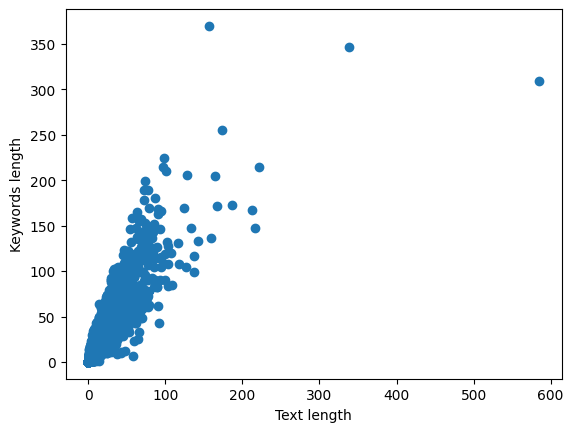

In [ ]:
plt.scatter(test_text_len, test_keywords_len)
plt.xlabel('Text length')
plt.ylabel('Keywords length')

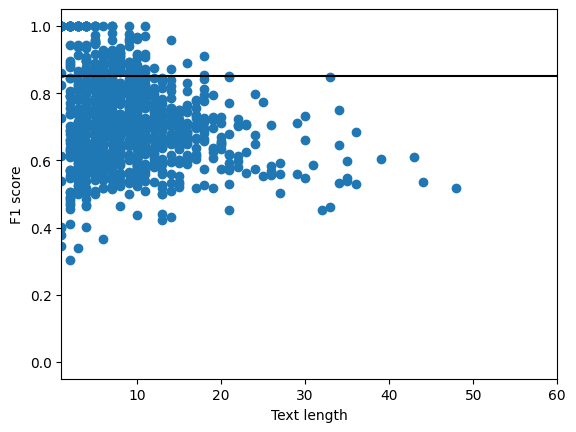

In [ ]:
plt.scatter(test_text_len[:1000], f1)
plt.xlim(1, 60)
plt.xlabel('Text length')
plt.ylabel('F1 score')
plt.hlines(y = 0.85, xmin = 1, xmax = 60, color = 'black')

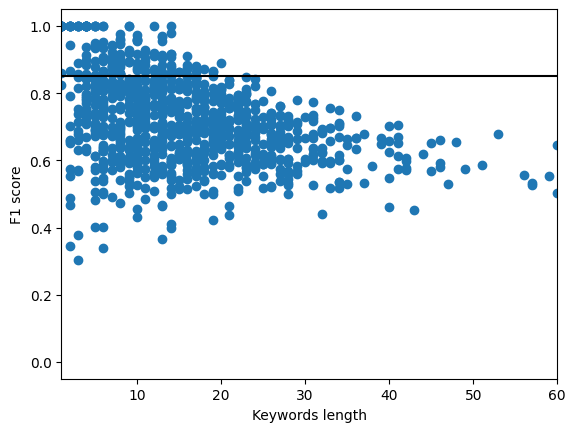

In [ ]:
plt.scatter(test_keywords_len[:1000], f1)
plt.xlim(1, 60)
plt.xlabel('Keywords length')
plt.ylabel('F1 score')
plt.hlines(y = 0.85, xmin = 1, xmax = 60, color = 'black')

Text(0, 0.5, 'Frequency')

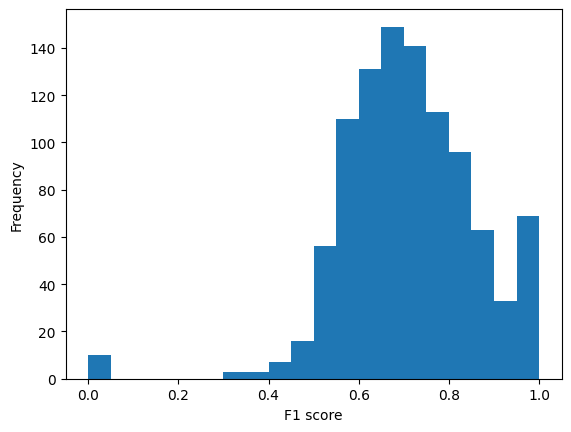

In [ ]:
plt.hist(f1, bins=20)
plt.xlabel('F1 score')
plt.ylabel('Frequency')

In [ ]:
np.median(f1[test_keywords_len[:1000] < 7])

np.float32(0.83406013)

In [ ]:
key_len = np.arange(1, 100, 1)
f1_median = []
for n in key_len:
  f1_median.append(np.median(f1[test_keywords_len[:1000] == n]))

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


(2.0, 100.0)

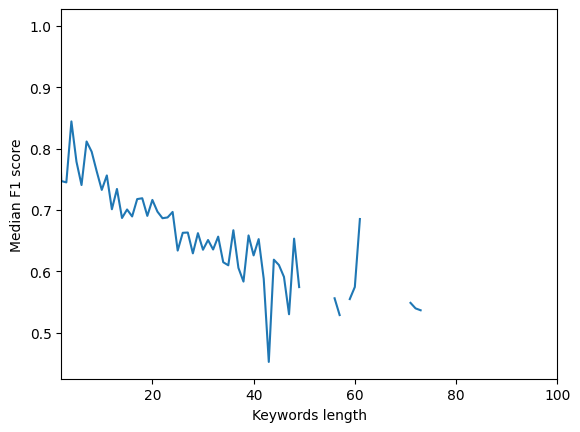

In [ ]:
plt.plot(key_len, f1_median)
plt.xlabel('Keywords length')
plt.ylabel('Median F1 score')
plt.xlim(2, 100)

In [ ]:
key_len = np.arange(1, 100, 1)
key_len_sum = []
for n in key_len:
  key_len_sum.append(sum(train_keywords_len == n))

(2, 100)

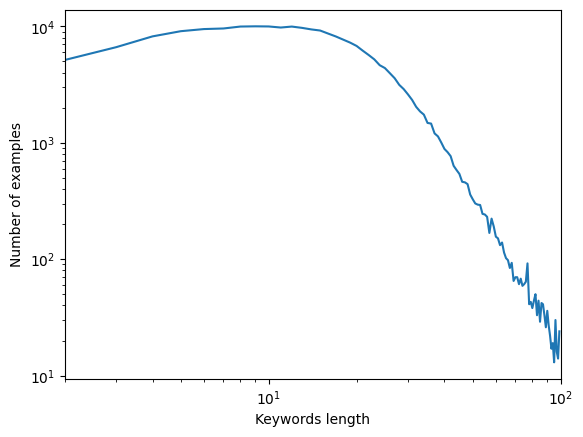

In [ ]:
plt.plot(key_len, key_len_sum)
plt.xlabel('Keywords length')
plt.ylabel('Number of examples')
plt.yscale('log')
plt.xscale('log')
plt.xlim(2, 100)

In [ ]:
np.median(f1[test_keywords_len[:1000] > 15])

np.float32(0.6699523)

In [ ]:
rouge_metric = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

In [ ]:
def print_rouge(rouge_n, ground_truth, predictions):

  fine_tuned_rouge1_prec = [rouge_metric.score(ground_truth.values[ind], predictions[ind])[rouge_n].precision for ind in range(batch_size)]
  fine_tuned_rouge1_recall = [rouge_metric.score(ground_truth.values[ind], predictions[ind])[rouge_n].recall for ind in range(batch_size)]
  fine_tuned_rouge1_fscore = [rouge_metric.score(ground_truth.values[ind], predictions[ind])[rouge_n].fmeasure for ind in range(batch_size)]

  print('Fine-tuned model (precision):', np.mean(fine_tuned_rouge1_prec))
  print('Fine-tuned model (recall):', np.mean(fine_tuned_rouge1_recall))
  print('Fine-tuned model (fscore):', np.mean(fine_tuned_rouge1_fscore))

In [ ]:
print_rouge('rouge1', y_test, answers_fine_tuned)

Fine-tuned model (precision): 0.7815785714285715
Fine-tuned model (recall): 0.7173626984126984
Fine-tuned model (fscore): 0.7367959112782642


In [ ]:
print_rouge('rougeL', y_test, answers_fine_tuned)

Fine-tuned model (precision): 0.776625
Fine-tuned model (recall): 0.7128277777777778
Fine-tuned model (fscore): 0.7321621339444868


In [ ]:
answers_fine_tuned_train = []
for train_text in X_train.values[:batch_size]:
    train_text = f"generate: {train_text}"
    input_ids = dwnld_tokenizer(train_text, return_tensors="pt").input_ids.to(device)
    output = dwnld_model.generate(input_ids, max_length=50, num_return_sequences=1)
    answers_fine_tuned_train.append(dwnld_tokenizer.decode(output[0], skip_special_tokens=True))

In [ ]:
bert_scores = [bert_scorer.score([answers_fine_tuned_train[ind]], [y_train.values[ind]]) for ind in range(batch_size)]
precision = [bert_scores[ind][0] for ind in range(batch_size)]
recall = [bert_scores[ind][1] for ind in range(batch_size)]
f1 = [bert_scores[ind][2] for ind in range(batch_size)]
print('Fine-tuned model (precision):', np.mean(precision))
print('Fine-tuned model (recall):', np.mean(recall))
print('Fine-tuned model (fscore):', np.mean(f1))

Fine-tuned model (precision): 0.7989736
Fine-tuned model (recall): 0.76531875
Fine-tuned model (fscore): 0.7803467


In [ ]:
print_rouge('rouge1', y_train, answers_fine_tuned_train)

Fine-tuned model (precision): 0.7471457182409611
Fine-tuned model (recall): 0.656958450029505
Fine-tuned model (fscore): 0.6880347117891051


In [ ]:
print_rouge('rougeL', y_train, answers_fine_tuned_train)

Fine-tuned model (precision): 0.7175770688845862
Fine-tuned model (recall): 0.6354185941376314
Fine-tuned model (fscore): 0.6636220572913438


In [ ]:
answers_fine_tuned_train = []
start = 10
for ind in range(10):
    train_text = X_train.values[start+ind]
    train_text = f"generate: {train_text}"
    input_ids = dwnld_tokenizer(train_text, return_tensors="pt").input_ids.to(device)
    output = dwnld_model.generate(input_ids, max_length=50)
    answers_fine_tuned_train.append(dwnld_tokenizer.decode(output[0], skip_special_tokens=True))

    print('Ground truth:', y_train.values[start+ind])
    print('Prediction (fine tuned model):', answers_fine_tuned_train[ind])
    print('Keywords:', X_train.values[start+ind])
    print('\n')
    print('***'*20)

Ground truth: I feel very embarrassed because I’m also a very athletic and in shape person.
Prediction (fine tuned model): I feel very embarrassed because I’m also a very athletic and in shape person.
Keywords: feel embarrassed athletic shape person .


************************************************************
Ground truth: Anyone know why?
Prediction (fine tuned model): Anyone know?
Keywords: know ?


************************************************************
Ground truth: Some other science thing?
Prediction (fine tuned model): Some other science thing?
Keywords: science thing ?


************************************************************
Ground truth: I moved to the UK couple of months ago and honestly I don't really know what I am doing with my life, it was my childhood dream to move to silicon valley Honeslty I have no idea what I am doing with my life, dysphoria is cripling me and only coping mechanisim I have is drowning myself in work and in alcohol.
Prediction (fine tun

In [ ]:
weights = (0.25, 0.25, 0, 0)  # Weights for uni-gram, bi-gram, tri-gram, and 4-gram

fine_tuned_bleu = [sentence_bleu([y_test.values[ind].split()], answers_fine_tuned[ind].split(), weights=weights, smoothing_function=SmoothingFunction().method1) for ind in range(batch_size)]
print('Fine-tuned model:', np.mean(fine_tuned_bleu))

Fine-tuned model: 0.51023058641632


# Fine tuning: hyperparameter search

In [ ]:
space = {
 'learning_rate': hp.loguniform('learning_rate', -2, -1),
#  'per_device_train_batch_size': hp.choice( 'per_device_train_batch_size', [8, 16, 32, 64]),
 'num_train_epochs': hp.choice('num_train_epochs', [1, 2, 3]),
 'weight_decay': hp.uniform('weight_decay', 0.0, 0.3),
}

In [ ]:
train_data = pd.DataFrame({'text': X_train.values, 'labels': y_train.values})
train_data.head()

In [ ]:
test_data = pd.DataFrame({'text': X_test.values, 'labels': y_test.values})
test_data.head()

In [ ]:
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])
        return item

    def __len__(self):
        return len(self.labels['input_ids'])

In [ ]:
train_encodings = dwnld_tokenizer(list(X_train.values), truncation=True, padding=True)
test_encodings = dwnld_tokenizer(list(X_test.values), truncation=True, padding=True)

train_label_encodings = dwnld_tokenizer(list(y_train.values), truncation=True, padding=True)
test_label_encodings = dwnld_tokenizer(list(y_test.values), truncation=True, padding=True)

In [ ]:
train_dataset = RedditDataset(train_encodings, train_label_encodings)
test_dataset = RedditDataset(test_encodings, test_label_encodings)

In [ ]:
def objective(hyperparams):
    model_repo = os.path.join(username, repo_name)
    dwnld_tokenizer = T5Tokenizer.from_pretrained(model_repo)
    dwnld_model = T5ForConditionalGeneration.from_pretrained(model_repo)
    dwnld_model = dwnld_model.to(device)

    training_args = TrainingArguments(
        output_dir=model_repo,
        learning_rate=hyperparams['learning_rate'],
        # per_device_train_batch_size=hyperparams['per_device_train_batch_size'],
        num_train_epochs=hyperparams['num_train_epochs'],
        weight_decay=hyperparams['weight_decay'],
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to=None
    )

    trainer = Trainer(
        model=dwnld_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    return {'loss': eval_results["eval_loss"], 'status': STATUS_OK}

In [ ]:
wandb login

In [ ]:
best = fmin(
    fn=objective,
    space=space,
    max_evals=3,
    trials=Trials()
)